## Ray Marching inside Renderer

In [41]:
import os
os.environ["PYOPENGL_PLATFORM"] = "egl"

import numpy as np
import trimesh
from PIL import Image, ImageEnhance
import pyrender
import random
from typing import Optional
from pyrender.constants import RenderFlags
import matplotlib.pyplot as plt

def norm(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

class Scene:
    def __init__(self, mesh, image_width: int = 640, image_height: int = 480) -> None:

        self.image_width = image_width
        self.image_height = image_height
        
        naruto_mesh = pyrender.Mesh.from_trimesh(mesh)
        naruto_pose = np.eye(4)
        naruto_pose[1, 3] = -1
        
        self.pyrender_scene = pyrender.Scene(ambient_light=[0.5, 0.5, 0.5])
        self.pyrender_scene.add(naruto_mesh, pose=naruto_pose)
        
        self.renderer = pyrender.OffscreenRenderer(image_width, image_height)
        camera = pyrender.PerspectiveCamera(yfov = np.pi / 3.0, aspectRatio=1.0)
        self.camera_node = pyrender.Node(camera=camera)
        self.pyrender_scene.add_node(self.camera_node)

        self.point_clouds = []

        self.T = np.array([
            [1, 0, 0],
            [0, -1, 0],
            [0, 0, -1]
        ])

        self.intrinsics_matrix()
        
    def add_points(self, points: np.ndarray, radius: float = 0.01, color: list[float] = [0, 0, 0.5]) -> None:
        sm = trimesh.creation.uv_sphere(radius=radius)
        sm.visual.vertex_colors = color
        tfs = np.tile(np.eye(4), (len(points), 1, 1))
        tfs[:,:3,3] = points
        pts = pyrender.Mesh.from_trimesh(sm, poses=tfs)
        node = self.pyrender_scene.add(pts)
        self.point_clouds.append(node)

    def remove_all_points(self) -> None:
        for ptsc in self.point_clouds:
            self.pyrender_scene.remove_node(ptsc)
        self.point_clouds = []
        
    def sample(self, alpha: Optional[float] = None, beta: Optional[float] = None, gamma: Optional[float] = None, return_depth: bool = False) -> [Image.Image, np.ndarray, np.ndarray]:
        rand = np.random.uniform(0, 360, (3)) * np.pi / 180
        if alpha == None:
            alpha = rand[0]
        else:
            alpha *= np.pi / 180
        if beta == None:
            beta = rand[1]
        else:
            beta *= np.pi / 180
        if gamma ==  None:
            gamma = rand[2]
        else:
            gamma *= np.pi / 180
        Rx = np.array([
                            [1, 0, 0, 0],
                            [0, np.cos(alpha), -np.sin(alpha), 0],
                            [0, np.sin(alpha), np.cos(alpha), 0],
                            [0, 0, 0, 1]]
                        )
        Ry = np.array([
                            [np.cos(beta), 0, np.sin(beta), 0],
                            [0, 1, 0, 0],
                            [-np.sin(beta), 0, np.cos(beta), 0],
                            [0, 0, 0, 1]]
                        )
        Rz = np.array([
                            [np.cos(gamma), -np.sin(gamma), 0, 0],
                            [np.sin(gamma), np.cos(gamma), 0, 0],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]]
                        )
        camera_pose = Rx @ Ry @ Rz @ np.array([
                            [1, 0, 0, 0],
                            [0, 1, 0, 0],
                            [0, 0, 1, 2],
                            [0, 0, 0, 1]]
                        )
        self.pyrender_scene.set_pose(self.camera_node, camera_pose)
        color, depth = self.renderer.render(self.pyrender_scene)
        image = Image.fromarray(color)
        enhancer = ImageEnhance.Brightness(image)
        image = enhancer.enhance(2.0)
        if not return_depth:
            depth[depth > 0] = 1
        return image, camera_pose, depth

    def cast_rays(self, camera_pose: np.ndarray, mask: np.ndarray, EPS: float = 1e-2):
        K = self.intrinsics_matrix()
        
        _fx = K[0, 0]
        _fy = K[1, 1]
        _cx = K[0, 2]
        _cy = K[1, 2]
    
        pose = camera_pose[:3, :3]
        pos = camera_pose[:3, 3]
        
        seg = np.where(mask > 0)
        x, y = seg[1], seg[0]
        
        normalized_x = x.astype(np.float32) - _cx
        normalized_y = y.astype(np.float32) - _cy
    
        dx = normalized_x / _fx
        dy = normalized_y / _fy
        dz = np.ones_like(dy)
        
        rays = np.vstack((dx, dy, dz)).T
        p1 = pose @ pos
        for ray in rays:
            dirc = pose @ self.T @ norm(ray)
            p2 = dirc * EPS
            for _ in range(15):
                self.ray_step(p1, p2)

    def ray_step(self, p1: np.ndarray, p2: np.ndarray):
        direction = p2 - p1
        direction = direction / np.linalg.norm(direction)
    
        step_x = 1.0 if direction[0] > 0 else -1.0
        step_y = 1.0 if direction[1] > 0 else -1.0
        step_z = 1.0 if direction[2] > 0 else -1.0
    
        t_max_x = (np.floor(p1[0]) + (step_x > 0) - p1[0]) / direction[0] if direction[0] != 0 else np.inf
        t_max_y = (np.floor(p1[1]) + (step_y > 0) - p1[1]) / direction[1] if direction[1] != 0 else np.inf
        t_max_z = (np.floor(p1[2]) + (step_z > 0) - p1[2]) / direction[2] if direction[2] != 0 else np.inf
    
        t_delta_x = abs(1.0 / direction[0]) if direction[0] != 0 else np.inf
        t_delta_y = abs(1.0 / direction[1]) if direction[1] != 0 else np.inf
        t_delta_z = abs(1.0 / direction[2]) if direction[2] != 0 else np.inf
    
        if t_max_x < t_max_y:
            if t_max_x < t_max_z:
                p1 += t_max_x * direction
                p1[0] = np.floor(p1[0]) + (step_x > 0)
            else:
                p1 += t_max_z * direction
                p1[2] = np.floor(p1[2]) + (step_z > 0)
        else:
            if t_max_y < t_max_z:
                p1 += t_max_y * direction
                p1[1] = np.floor(p1[1]) + (step_y > 0)
            else:
                p1 += t_max_z * direction
                p1[2] = np.floor(p1[2]) + (step_z > 0)
    
        return p1

    def intrinsics_matrix(self):

        P = self.camera_node.camera.get_projection_matrix()
        self.fx = P[0, 0] * self.image_width / 2
        self.fy = P[1, 1] * self.image_height / 2
        self.cx = (1.0 - P[0, 2]) * self.image_width / 2
        self.cy = (1.0 + P[1, 2]) * self.image_height / 2
    
        K = np.array([[self.fx, 0, self.cx], [0, self.fy, self.cy], [0, 0, 1]])
    
        return K

    def convert_2d_to_3d(self, points2d: np.ndarray, pose: np.ndarray, depth: np.ndarray) -> np.ndarray:
        x = points2d[:, 0]
        y = points2d[:, 1]
        
        normalized_x = x.astype(np.float32) - self.cx
        normalized_y = y.astype(np.float32) - self.cy
        
        world_x = normalized_x * depth[y, x] / self.fx
        world_y = normalized_y * depth[y, x] / self.fy
        world_z = depth[y, x] - 2
        
        points3d = np.vstack((world_x, world_y, world_z)).T
        
        points3d = (pose[:3, :3] @ self.T @ points3d.T).T
        
        return points3d

mesh = trimesh.load("./Naruto/Naruto.obj", force="mesh")
scene = Scene(mesh = mesh)
image, pose, mask = scene.sample()

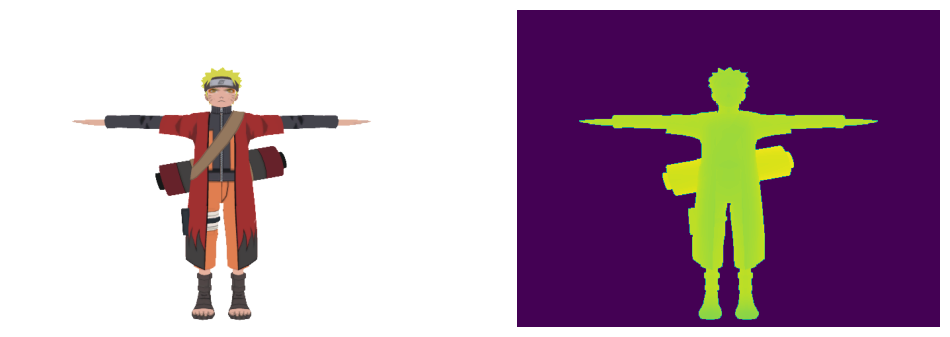

Camera Pose: [[-0.11570585  0.22321298 -0.96787815 -1.93575631]
 [ 0.7756333  -0.58840172 -0.22842153 -0.45684307]
 [-0.62048783 -0.77714823 -0.1050499  -0.2100998 ]
 [ 0.          0.          0.          1.        ]]


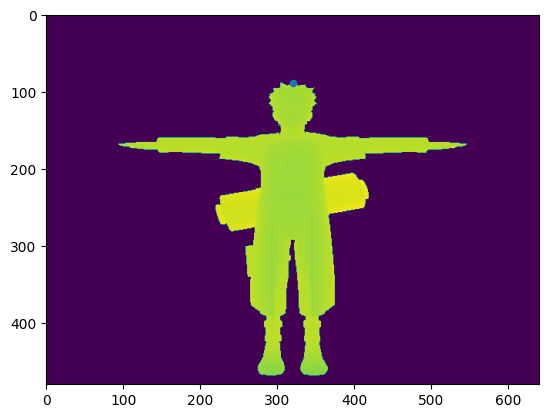

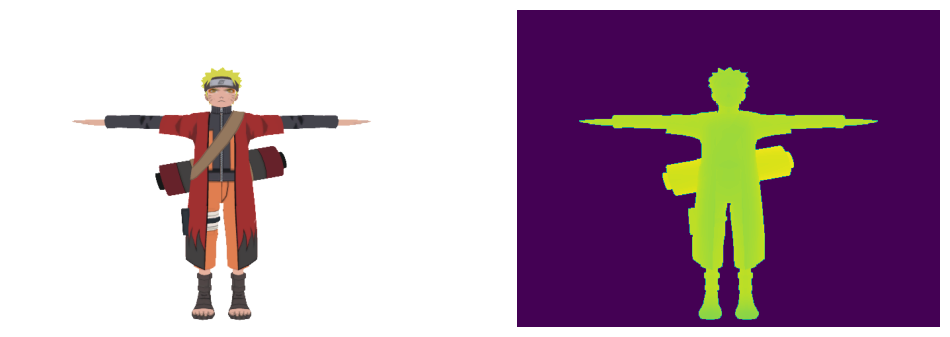

Camera Pose: [[-0.11570585  0.22321298 -0.96787815 -1.93575631]
 [ 0.7756333  -0.58840172 -0.22842153 -0.45684307]
 [-0.62048783 -0.77714823 -0.1050499  -0.2100998 ]
 [ 0.          0.          0.          1.        ]]


In [42]:
scene.remove_all_points()
image, camera_pose, mask = scene.sample(0, 0, 0, return_depth=True)
_, axs = plt.subplots(1, 2, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip([image, mask], axs):
    ax.imshow(img)
    ax.set_axis_off()
plt.show()
print("Camera Pose:", pose)

seg = np.where(mask>0)
x, y = seg[1], seg[0]
plt.imshow(mask)
plt.scatter(x[0], y[0], s=20)
plt.show()

pt = scene.convert_2d_to_3d(np.array([[x[0], y[0]]]), pose, mask)
scene.add_points(pt)
image, camera_pose, mask = scene.sample(0, 0, 0, return_depth=True)
_, axs = plt.subplots(1, 2, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip([image, mask], axs):
    ax.imshow(img)
    ax.set_axis_off()
plt.show()
print("Camera Pose:", pose)

In [43]:
pt

array([[ 0.13776035, -0.43062639, -0.56398826]])

array([[-0.62204867,  0.10478226, -0.35295309]])

In [6]:
np.concatenate((np.array([1, 2, 3]), np.array([4])))

array([1, 2, 3, 4])

In [3]:
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

class Voxelizer:
    def __init__(self, origin, size, n_voxels, num_images):
        self.origin = origin
        self.size = size
        self.n_voxels = n_voxels
        self.num_images = num_images
        self.voxel_size = (
            size[0] / n_voxels[0],
            size[1] / n_voxels[1],
            size[2] / n_voxels[2]
        )
        self.weights = np.zeros((self.n_voxels[0], self.n_voxels[1], self.n_voxels[2], self.num_images), dtype=np.float32)
        self.shade = np.zeros((self.n_voxels[0], self.n_voxels[1], self.n_voxels[2], 3), dtype=np.float32)

    def get_voxel(self, x, y, z):
        a, b, c = self.origin
        h, w, d = self.size

        if not (a <= x <= a + h and b <= y <= b + w and c <= z <= c + d):
            raise ValueError("Point is outside the volume")

        i = int((x - a) / self.voxel_size[0])
        j = int((y - b) / self.voxel_size[1])
        k = int((z - c) / self.voxel_size[2])

        i = min(i, self.n_voxels[0] - 1)
        j = min(j, self.n_voxels[1] - 1)
        k = min(k, self.n_voxels[2] - 1)

        return (i, j, k)

    def reset(self):
        self.weights = np.zeros((self.n_voxels[0], self.n_voxels[1], self.n_voxels[2], self.num_images), dtype=float)

    def update_weight(self, x, y, z, img_idx):
        try:
            i, j, k = self.get_voxel(x, y, z)
            self.weights[i, j, k, img_idx] = 1
        except:
            return 0

    def ray_cast(self, p1, dirc, n_steps=25, verbose: bool = False):
        points = []
        voxels = []

        a, b, c = self.origin
        h, w, d = self.size
        voxel_size_x, voxel_size_y, voxel_size_z = self.voxel_size
        nx, ny, nz = self.n_voxels
        dirc = dirc / np.linalg.norm(dirc)

        # Compute the entry and exit points of the ray with the volume
        bounds_min = np.array([a, b, c])
        bounds_max = bounds_min + np.array([h, w, d])

        t_min = (bounds_min - p1) / dirc
        t_max = (bounds_max - p1) / dirc

        t1 = np.minimum(t_min, t_max)
        t2 = np.maximum(t_min, t_max)

        t_enter = np.max(t1)
        t_exit = np.min(t2)

        if t_enter > t_exit or t_exit < 0:
            if verbose:
                print("Ray does not intersect the volume.")
            return points, voxels  # Empty lists

        # Adjust t_enter if it's negative (ray starts inside the volume)
        t_enter = max(t_enter, 0.0)

        # Calculate the starting point within the volume
        p_start = p1 + dirc * t_enter

        # Get the starting voxel indices
        try:
            i, j, k = self.get_voxel(p_start[0], p_start[1], p_start[2])
        except ValueError:
            if verbose:
                print("Starting point after entering volume is outside. Exiting ray_cast.")
            return points, voxels

        # Initialize tMax and tDelta
        if dirc[0] != 0:
            if dirc[0] > 0:
                next_voxel_boundary_x = a + (i + 1) * voxel_size_x
            else:
                next_voxel_boundary_x = a + i * voxel_size_x
            tMaxX = (next_voxel_boundary_x - p1[0]) / dirc[0]
            tDeltaX = voxel_size_x / abs(dirc[0])
        else:
            tMaxX = float('inf')
            tDeltaX = float('inf')

        if dirc[1] != 0:
            if dirc[1] > 0:
                next_voxel_boundary_y = b + (j + 1) * voxel_size_y
            else:
                next_voxel_boundary_y = b + j * voxel_size_y
            tMaxY = (next_voxel_boundary_y - p1[1]) / dirc[1]
            tDeltaY = voxel_size_y / abs(dirc[1])
        else:
            tMaxY = float('inf')
            tDeltaY = float('inf')

        if dirc[2] != 0:
            if dirc[2] > 0:
                next_voxel_boundary_z = c + (k + 1) * voxel_size_z
            else:
                next_voxel_boundary_z = c + k * voxel_size_z
            tMaxZ = (next_voxel_boundary_z - p1[2]) / dirc[2]
            tDeltaZ = voxel_size_z / abs(dirc[2])
        else:
            tMaxZ = float('inf')
            tDeltaZ = float('inf')

        # Adjust tMax values based on t_enter
        if tMaxX < t_enter:
            tMaxX += ((t_enter - tMaxX) // tDeltaX + 1) * tDeltaX
        if tMaxY < t_enter:
            tMaxY += ((t_enter - tMaxY) // tDeltaY + 1) * tDeltaY
        if tMaxZ < t_enter:
            tMaxZ += ((t_enter - tMaxZ) // tDeltaZ + 1) * tDeltaZ

        # Compute the step direction
        stepX = 1 if dirc[0] > 0 else -1
        stepY = 1 if dirc[1] > 0 else -1
        stepZ = 1 if dirc[2] > 0 else -1

        t = t_enter
        current_voxel = (i, j, k)
        current_point = p_start.copy()

        for step in range(n_steps):
            # Check if the indices are within the volume
            if not (0 <= i < nx and 0 <= j < ny and 0 <= k < nz):
                if verbose:
                    print(f"Ray has exited the volume at step {step}")
                break

            voxels.append(current_voxel)
            points.append(current_point.copy())

            # Determine the next voxel to step into
            if tMaxX < tMaxY:
                if tMaxX < tMaxZ:
                    # Step in x direction
                    t = tMaxX
                    tMaxX += tDeltaX
                    i += stepX
                else:
                    # Step in z direction
                    t = tMaxZ
                    tMaxZ += tDeltaZ
                    k += stepZ
            else:
                if tMaxY < tMaxZ:
                    # Step in y direction
                    t = tMaxY
                    tMaxY += tDeltaY
                    j += stepY
                else:
                    # Step in z direction
                    t = tMaxZ
                    tMaxZ += tDeltaZ
                    k += stepZ

            # Update current point
            current_point = p1 + dirc * t

            # Update current voxel
            current_voxel = (i, j, k)

            # Check if we've reached the exit point
            if t > t_exit:
                if verbose:
                    print(f"Ray has exited the volume at step {step}")
                break

        return points, voxels

    def show(self, thresh: float = 0):
        """
        Plot the voxel grid and any non-zero weight voxels.
        """
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Plot the volume boundaries
        a, b, c = self.origin
        h, w, d = self.size
        x = [a, a + h]
        y = [b, b + w]
        z = [c, c + d]
        # Draw the edges of the cuboid
        for s, e in combinations(np.array(list(product(x, y, z))), 2):
            if np.sum(np.abs(s - e)) in [h, w, d]:
                ax.plot3D(*zip(s, e), color="k")

        # Plot non-zero weight voxels
        filled = np.sum(self.weights, axis=-1) > thresh
        if np.any(filled):
            nx, ny, nz = self.n_voxels
            x_edges = np.linspace(a, a + h, nx + 1)
            y_edges = np.linspace(b, b + w, ny + 1)
            z_edges = np.linspace(c, c + d, nz + 1)
            x_centers = x_edges[:-1] + self.voxel_size[0] / 2
            y_centers = y_edges[:-1] + self.voxel_size[1] / 2
            z_centers = z_edges[:-1] + self.voxel_size[2] / 2
            filled_positions = np.argwhere(filled)
            xs = x_centers[filled_positions[:, 0]]
            ys = y_centers[filled_positions[:, 1]]
            zs = z_centers[filled_positions[:, 2]]
            ax.scatter(xs, ys, zs, c='red', marker='s', s=50, alpha=0.5)
        else:
            print("No non-zero weight voxels to display.")

        ax.set_xlim(a, a + h)
        ax.set_ylim(b, b + w)
        ax.set_zlim(c, c + d)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

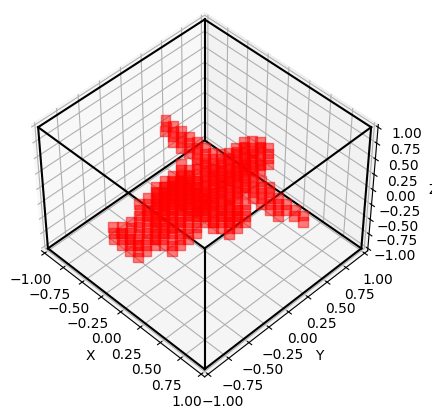

In [4]:
from tqdm.notebook import tqdm
import numpy as np
from itertools import product, combinations
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot(ax, voxelizer, time):
    
    a, b, c = voxelizer.origin
    h, w, d = voxelizer.size
    x = [a, a + h]
    y = [b, b + w]
    z = [c, c + d]

    for s, e in combinations(np.array(list(product(x, y, z))), 2):
        if np.sum(np.abs(s - e)) in [h, w, d]:
            ax.plot3D(*zip(s, e), color="k")
    
    # Plot non-zero weight voxels
    filled = np.sum(voxelizer.weights, axis=-1) > time
    if np.any(filled):
        nx, ny, nz = voxelizer.n_voxels
        x_edges = np.linspace(a, a + h, nx + 1)
        y_edges = np.linspace(b, b + w, ny + 1)
        z_edges = np.linspace(c, c + d, nz + 1)
        x_centers = x_edges[:-1] + voxelizer.voxel_size[0] / 2
        y_centers = y_edges[:-1] + voxelizer.voxel_size[1] / 2
        z_centers = z_edges[:-1] + voxelizer.voxel_size[2] / 2
        filled_positions = np.argwhere(filled)
        xs = x_centers[filled_positions[:, 0]]
        ys = y_centers[filled_positions[:, 1]]
        zs = z_centers[filled_positions[:, 2]]
        ax.scatter(xs, ys, zs, c='red', marker='s', s=50, alpha=0.5)
    else:
        print("No non-zero weight voxels to display.")
    
    ax.set_xlim(a, a + h)
    ax.set_ylim(b, b + w)
    ax.set_zlim(c, c + d)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(azim=-45, elev=45)
    # plt.show()

N = 20

voxelizer = Voxelizer(
    [-1, -1, -1],
    [2, 2, 2],
    [20, 20, 20],
    N
)

K = scene.intrinsics_matrix()

_fx = K[0, 0]
_fy = K[1, 1]
_cx = K[0, 2]
_cy = K[1, 2]

exp_name = "naruto_20"
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
reconstruction_folder = f'output/{exp_name}/reconstruction/'
vis_path = f'output/{exp_name}/animation.gif'
if not os.path.exists(reconstruction_folder):
    os.makedirs(reconstruction_folder)

for i in tqdm(range(N)):

    image, camera_pose, mask = scene.sample()
    
    pose = camera_pose[:3, :3]
    pos = np.array([0, 0, 2])
    
    seg = np.where(mask > 0)
    x, y = seg[1], seg[0]
    
    normalized_x = x.astype(np.float32) - _cx
    normalized_y = y.astype(np.float32) - _cy
    
    dx = normalized_x / _fx
    dy = normalized_y / _fy
    dz = np.ones_like(dy)
    
    rays = np.vstack((dx, dy, dz)).T
    p1 = pose @ pos
    for ray in rays:
        dirc = pose @ scene.T @ norm(ray)
        points, voxel = voxelizer.ray_cast(p1, dirc, 1000)
        for v in points:
            voxelizer.update_weight(v[0], v[1], v[2], i)

    plt.cla()
    plot(ax, voxelizer, i)
    plt.savefig(f"{reconstruction_folder}{i}_images.png")

# scene.remove_all_points()
# scene.add_points(points, radius=0.02)
# i, p, m = scene.sample(-45, -45, 0, return_depth=True)
# scene.remove_all_points()

# _, axs = plt.subplots(1, 2, figsize=(12, 12))
# axs = axs.flatten()
# for img, ax in zip([i, m], axs):
#     ax.imshow(img)
#     ax.set_axis_off()
# plt.show()
# print("Camera Pose:", pose)
# np.linalg.norm(norm(points[1] - points[0]) - norm(dirc))

Segmentation complete. Shape: (20, 20, 20)


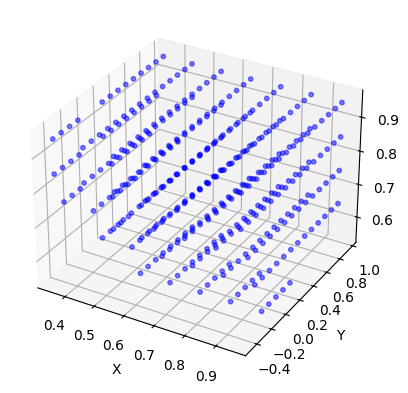

In [5]:
import maxflow

def volumetric_graph_cut(voxelizer, threshold=0.5):
    """
    Perform volumetric graph cut on the voxel grid.

    Parameters:
    - voxelizer: Voxelizer object, containing voxel grid and weights.
    - threshold: float, value above which voxels are treated as foreground likelihood.

    Returns:
    - segmentation: numpy array of shape (nx, ny, nz), binary segmentation of the voxel grid.
    """
    nx, ny, nz = voxelizer.n_voxels
    num_voxels = nx * ny * nz

    # Create a graph with 'num_voxels' nodes
    graph = maxflow.Graph[float](num_voxels, 6 * num_voxels)
    nodes = graph.add_nodes(num_voxels)

    def flatten_index(i, j, k):
        return i * (ny * nz) + j * nz + k

    # Iterate through the voxel grid and set up the unary and pairwise potentials
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                idx = flatten_index(i, j, k)
                weight_sum = np.sum(voxelizer.weights[i, j, k, :])

                # Set the t-link weights (unary potentials)
                if weight_sum > threshold:
                    # High weight -> more likely to be foreground
                    graph.add_tedge(nodes[idx], weight_sum, 0)
                else:
                    # Low weight -> more likely to be background
                    graph.add_tedge(nodes[idx], 0, 1 - weight_sum)

                # Set the n-link weights (pairwise potentials)
                # Connect to neighbors in x, y, z directions
                for di, dj, dk in [(1, 0, 0), (0, 1, 0), (0, 0, 1)]:
                    ni, nj, nk = i + di, j + dj, k + dk
                    if 0 <= ni < nx and 0 <= nj < ny and 0 <= nk < nz:
                        neighbor_idx = flatten_index(ni, nj, nk)
                        # Smoothness term: encourage neighboring voxels to have the same label
                        smoothness_weight = 1.0  # You can adjust this value based on your needs
                        graph.add_edge(nodes[idx], nodes[neighbor_idx], smoothness_weight, smoothness_weight)

    # Compute the max-flow/min-cut
    graph.maxflow()

    # Create segmentation array from graph cut result
    segmentation = np.zeros((nx, ny, nz), dtype=np.bool_)
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                idx = flatten_index(i, j, k)
                segmentation[i, j, k] = graph.get_segment(nodes[idx]) == 1

    return segmentation

# Example usage
segmentation = volumetric_graph_cut(voxelizer)
print("Segmentation complete. Shape:", segmentation.shape)  # Binary mask of the voxel grid

# Visualize the segmentation result (foreground voxels)
filled_positions = np.argwhere(segmentation)
x_centers = np.linspace(voxelizer.origin[0], voxelizer.origin[0] + voxelizer.size[0], voxelizer.n_voxels[0], endpoint=False) + voxelizer.voxel_size[0] / 2
y_centers = np.linspace(voxelizer.origin[1], voxelizer.origin[1] + voxelizer.size[1], voxelizer.n_voxels[1], endpoint=False) + voxelizer.voxel_size[1] / 2
z_centers = np.linspace(voxelizer.origin[2], voxelizer.origin[2] + voxelizer.size[2], voxelizer.n_voxels[2], endpoint=False) + voxelizer.voxel_size[2] / 2
xs = x_centers[filled_positions[:, 0]]
ys = y_centers[filled_positions[:, 1]]
zs = z_centers[filled_positions[:, 2]]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, c='blue', marker='o', s=10, alpha=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [ ]:
maxflow.Graph

In [ ]:
import imageio

frames = []
for i in range(N):
    frames.append(imageio.imread(f"{reconstruction_folder}{i}_images.png"))
# imageio.mimsave(vid_path, frames, format='mp4', fps=30)
imageio.mimsave(vis_path, frames, format='GIF', fps=10, loop=0)

In [ ]:
import numpy as np
from itertools import product, combinations
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the volume boundaries
a, b, c = voxelizer.origin
h, w, d = voxelizer.size
x = [a, a + h]
y = [b, b + w]
z = [c, c + d]
# Draw the edges of the cuboid
for s, e in combinations(np.array(list(product(x, y, z))), 2):
    if np.sum(np.abs(s - e)) in [h, w, d]:
        ax.plot3D(*zip(s, e), color="k")

# Plot non-zero weight voxels
filled = np.sum(voxelizer.weights, axis=-1) > N - 1
if np.any(filled):
    nx, ny, nz = voxelizer.n_voxels
    x_edges = np.linspace(a, a + h, nx + 1)
    y_edges = np.linspace(b, b + w, ny + 1)
    z_edges = np.linspace(c, c + d, nz + 1)
    x_centers = x_edges[:-1] + voxelizer.voxel_size[0] / 2
    y_centers = y_edges[:-1] + voxelizer.voxel_size[1] / 2
    z_centers = z_edges[:-1] + voxelizer.voxel_size[2] / 2
    filled_positions = np.argwhere(filled)
    xs = x_centers[filled_positions[:, 0]]
    ys = y_centers[filled_positions[:, 1]]
    zs = z_centers[filled_positions[:, 2]]
    ax.scatter(xs, ys, zs, c='red', marker='s', s=50, alpha=0.5)
else:
    print("No non-zero weight voxels to display.")

ax.set_xlim(a, a + h)
ax.set_ylim(b, b + w)
ax.set_zlim(c, c + d)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(azim=-45, elev=45)
plt.show()

In [ ]:
def norm(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

T = np.array([
    [1, 0, 0],
    [0, -1, 0],
    [0, 0, -1]
])

K = scene.intrinsics_matrix()

_fx = K[0, 0]
_fy = K[1, 1]
_cx = K[0, 2]
_cy = K[1, 2]

seg = np.where(mask > 0)
x, y = seg[1], seg[0]

normalized_x = x.astype(np.float32) - _cx
normalized_y = y.astype(np.float32) - _cy
pose[:3, :3]
dx = normalized_x / _fx
dy = normalized_y / _fy
dz = np.ones_like(dy)

rays = np.vstack((dx, dy, dz)).T
proj = (T @ ((rays * mask[y, x][:, None]) - np.array([[0, 0, 2]])).T).T

idx = np.random.randint(0, len(x))
ray_point = [pose[:3, :3] @ proj[idx], pose[:3, :3] @ np.array([0, 0, 2])]
dirc = pose[:3, :3] @ T @ norm(rays[idx])
step = 0.1
for _ in range(15):
    rt = ray_point[-1] + step * dirc
    ray_point.append(rt)

scene.remove_all_points()
scene.add_points(ray_point, radius=0.02)
i, p, m = scene.sample(-55, 45, 0, return_depth=True)
scene.remove_all_points()

_, axs = plt.subplots(1, 2, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip([i, m], axs):
    ax.imshow(img)
    ax.set_axis_off()
plt.show()
print("Camera Pose:", pose)
np.linalg.nor(norm(ray_point[0] - ray_point[1]) - dirc)

In [ ]:
def depth_to_pointcloud(K: np.ndarray, depth: np.ndarray, rgb: np.ndarray = None):
    """Convert depth image to pointcloud given camera intrinsics.
    Args:
        depth (np.ndarray): Depth image.
    Returns:
        np.ndarray: (x, y, z) Point cloud. [n, 4]
        np.ndarray: (r, g, b) RGB colors per point. [n, 3] or None
    """
    _fx = K[0, 0]
    _fy = K[1, 1]
    _cx = K[0, 2]
    _cy = K[1, 2]

    # Mask out invalid depth
    mask = np.where(depth > 0)
    x, y = mask[1], mask[0]

    # Normalize pixel coordinates
    normalized_x = x.astype(np.float32) - _cx
    normalized_y = y.astype(np.float32) - _cy

    # Convert to world coordinates
    world_x = normalized_x * depth[y, x] / _fx
    world_y = normalized_y * depth[y, x] / _fy
    world_z = depth[y, x] - 2

    pc = np.vstack((world_x, world_y, world_z)).T

    # Assign rgb colors to points if available
    if rgb is not None:
        rgb = rgb[y, x, :]

    return pc, rgb

point_cloud, _ = depth_to_pointcloud(scene.intrinsics_matrix(), mask)

T = np.array([
    [1, 0, 0],
    [0, -1, 0],
    [0, 0, -1]
])
pts = (pose[:3, :3] @ T @ point_cloud.T).T
scene.add_points(pts)
# scene.add_points([[0, 0, 1], [0, 0, 0.5]])
# scene.remove_all_points()
image, pose, mask = scene.sample(0, 90, 0, return_depth=True)
_, axs = plt.subplots(1, 2, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip([image, mask], axs):
    ax.imshow(img)
    ax.set_axis_off()
plt.show()
print("Camera Pose:", pose)

In [ ]:
K = scene.intrinsics_matrix()

_fx = K[0, 0]
_fy = K[1, 1]
_cx = K[0, 2]
_cy = K[1, 2]

seg = np.where(mask > 0)
x, y = seg[1], seg[0]

normalized_x = x.astype(np.float32) - _cx
normalized_y = y.astype(np.float32) - _cy

dx = normalized_x / _fx
dy = normalized_y / _fy
dz = np.ones_like(dy)

rays = np.vstack((dx, dy, dz)).T
rays.shape